# Computer-assisted drug discovery
###### Zoë Vergouwe, Misha Zekveld, Valeria Montijn, Julia Kersting, Rinus Verhoef, Joanne van den Bergh, Annefleur van Will, Lilian van Stokkum
###### Group 14
Computer-assisted drug discovery (CADD) is a rapidly growing field that involves the use of computational approaches in the discovery and design of small-molecule drugs. in this code  kinase inhibitors are identified that selectively target a specific kinase while minimizing off-target effects. the two inhibitors are Pyruvate kinase type M2 (PKM2) and Extracellular signal-Regulated Kinase 2 (ERK2). Molecules that are tested based of descriptors if they can inhibit or not and are graded on this to find the best inhibiting moelcules to test in the lab, minimizing false positives and false negatives.
#### Layout:
- Importing libraries
- Opening files
- Scaling and PCA
- Data boxplots
- train_test_split
- GridSearchCV
- Accuracy
- Confusion Matrices
- Scores
- Untested molecules
## Importing libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import random

sns.set()
plt.rcParams['figure.figsize'] = 7,5  # defualt size of plots
plt.rcParams['lines.markeredgewidth'] = 1  # to fix issue with seaborn box plots; needed 

## Opening files
also splitting the files so it doenst take the first column of SMILES and splitting the features form the target inhibition columns.

In [2]:
df_results = pd.read_csv('Data/tested_molecules.csv')
df_mpg = pd.read_csv('Data/data_descriptors.csv')

# Prepare the features and target
features = df_mpg.columns[1:]
X = df_mpg[features]
y = df_results['PKM2_inhibition']
y1 =df_results['ERK2_inhibition']
# Drop feautures with only 0 values
X = X.dropna(axis=1, how='all')

## Scaling and PCA
when that is done a figure is plotted of the cumulative explained variance

17


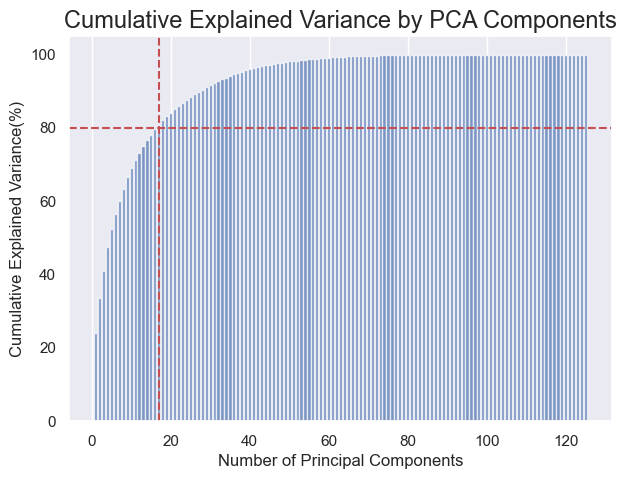

In [3]:
scaler =MinMaxScaler() 
X_scaled = scaler.fit_transform(df_mpg[features]) #scale the features data

pca = PCA()  #perform PCA for only the X data
X_pca = pca.fit_transform(X_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_) # Get the cumulative explained variance
num_components = np.argmax(cumulative_variance >= 0.8) + 1 # Number of components that captures at least 80% variance

plt.figure() # Plot a histogram of the cumulative explained variance
plt.bar(range(1, len(cumulative_variance) + 1), cumulative_variance*100, alpha=0.7, align='center')
plt.axhline(y=80, color='r', linestyle='--') #get the y point where it is 80%
plt.axvline(x=num_components, color='r', linestyle='--') # get the x point for 80%
plt.title('Cumulative Explained Variance by PCA Components', fontsize='17')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance(%)')
plt.grid(axis='y');

print(num_components)

## Data boxplots
Two box plots of the difference between the scaled and not scaled data

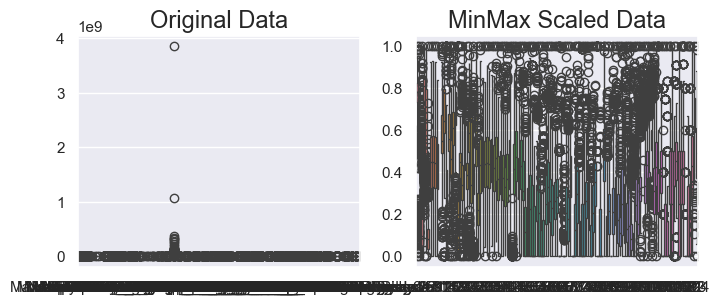

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3)) 
sns.boxplot(data=X, ax=axs[0])
sns.boxplot(data=X_scaled, ax=axs[1])

axs[0].set_title('Original Data', fontsize='17') 
axs[1].set_title('MinMax Scaled Data', fontsize='17');

## train_test_split
First perform PCA only for the selected components and split them into test and train data

In [5]:
pca = PCA(n_components=num_components) # only use the components that make up the 80% variance
X_pca_selected = pca.fit_transform(X_scaled)

pca_columns = [f"PC{i+1}" for i in range(num_components)]
df_pca_selected = pd.DataFrame(X_pca_selected, columns=pca_columns) # put it into a dataframe

# split the data
X_train_P, X_test_P, y_train_P, y_test_P = train_test_split(df_pca_selected, y, test_size=0.2, random_state=42)
X_train_E, X_test_E, y_train_E, y_test_E = train_test_split(df_pca_selected, y1, test_size=0.2, random_state=42)

## GridSearchCV
first get the logistic regression and use GrisSearchCV which is a technique to search through the best parameter values from the given set of the grid of parameters, to ge the best parameters

In [6]:
lr = LogisticRegression(class_weight='balanced', random_state=42) # Classifier 

# set possible parameters for the gridsearch
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['liblinear', 'saga'],  # 'liblinear' for l1 and l2, 'saga' for elasticnet
    'max_iter': [100, 500, 1000, 1500, 2000]
}

grid_search_E = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1) #Gridsearch for both inhibitors
grid_search_P = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1)
grid_search_E.fit(X_train_E, y_train_E) #refit it
grid_search_P.fit(X_train_P, y_train_P)

print(f"Best parameters: {grid_search_P.best_params_}") # show best parameters
print(f"Best score: {grid_search_P.best_score_}") # show best score
print(f"Best parameters: {grid_search_E.best_params_}")
print(f"Best score: {grid_search_E.best_score_}")

best_model_P = grid_search_P.best_estimator_ # Evaluate the model based on the test set
best_model_E = grid_search_E.best_estimator_
y_pred_P = best_model_P.predict(X_test_P) 
y_pred_E = best_model_E.predict(X_test_E)


C:\Users\20212774\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
500 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\20212774\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\20212774\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCac

Best parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.7767816091954023
Best parameters: {'C': 100, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
Best score: 0.6706912630413242


C:\Users\20212774\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
500 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\20212774\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\20212774\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCac

## Accuracy
Calculate the accuracy, first the non-weighted accuracy, with our balansed dataset. then the weighted accuracy. 

In [9]:
accuracy_E = accuracy_score(y_test_E, y_pred_E)
print(f'Accuracy_E: {accuracy_E}')
accuracy_P = accuracy_score(y_test_P, y_pred_P)
print(f'Accuracy_P: {accuracy_P}')

balanced_accuracy_E = balanced_accuracy_score(y_test_E, y_pred_E) # weighted accuracy ERK2
print(f"The weighted accuracy_E of the lr model is: {balanced_accuracy_E}")

balanced_accuracy_P = balanced_accuracy_score(y_test_P, y_pred_P) #weighted accuracy PKM
print(f"The weighted accuracy_P of the lr model is: {balanced_accuracy_P}")

cv_scores_P = cross_val_score(lr, X_scaled, y, cv=5, scoring="balanced_accuracy") # CV scores
print(f"The Cross-validation scores for PKM2 are: {cv_scores_P}")
print(f"The mean Cross-validation score for PKM2 is: {cv_scores_P.mean()}")

cv_scores_E = cross_val_score(lr, X_scaled, y1, cv=5, scoring="balanced_accuracy") # CV scores
print(f"The Cross-validation scores for ERK2 are: {cv_scores_E}")
print(f"The mean Cross-validation score for ERK2 is: {cv_scores_E.mean()}")


Accuracy_E: 0.6651785714285714
Accuracy_P: 0.7633928571428571
The weighted accuracy_E of the lr model is: 0.6177884615384616
The weighted accuracy_P of the lr model is: 0.8784403669724771
The Cross-validation scores for PKM2 are: [0.79892966 0.78073394 0.64266055 0.88210445 0.6624424 ]
The mean Cross-validation score for PKM2 is: 0.7533742020039741
The Cross-validation scores for ERK2 are: [0.55420401 0.43802817 0.65375587 0.59671362 0.67558685]
The mean Cross-validation score for ERK2 is: 0.5836577037985489


## Confusion Matrices
plots that show any false negatives or positives in the above mentioned predicted data. also show all rightly predicted inhibiton numbers

Text(0.5, 1.0, 'Confusion Matrix PKM2')

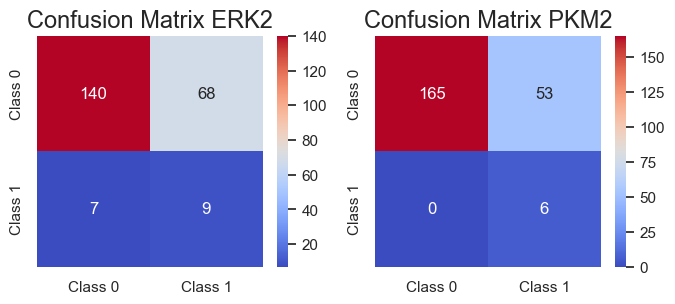

In [14]:
# Get confusion matrices
cm_E = confusion_matrix(y_test_E, y_pred_E)
cm_P = confusion_matrix(y_test_P, y_pred_P)

# Create figures
fig, axs = plt.subplots(1, 2, figsize=(8, 3) )
sns.heatmap(cm_E, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'],  ax=axs[0])
axs[0].set_title('Confusion Matrix ERK2', fontsize='17')

sns.heatmap(cm_P, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'], ax=axs[1])
axs[1].set_title('Confusion Matrix PKM2', fontsize='17')

## Scores
Get four scores for determining of the given model is optimal: precision, recall, F1, ROC AUC, respectively,  for both inhibits. First the scores for PKM and then in the next code blok the scores for EKR2.

And lastly for both ERK2 and PKM the cross_validation scores because we are looking at real world data which is often distributed more unevenly, meaning the fitted model might perform better in some sections so we also need to look at this score.

In [ ]:
# Scores for PKM2
precision_P = precision_score(y_test_P, y_pred_P) #precision score
print(f"Precision Score: {precision_P}")
recall_P = recall_score(y_test_P, y_pred_P) #recall score
print(f"Recall Score: {recall_P}")
f1_P = f1_score(y_test_P, y_pred_P) #F1 score
print(f"F1 Score: {f1_P}")
roc_auc_P = roc_auc_score(y_test_P, y_pred_P) #ROC AUC score
print(f"ROC AUC Score: {roc_auc_P}")

Precision Score: 0.10714285714285714
Recall Score: 0.5
F1 Score: 0.17647058823529413
ROC AUC Score: 0.6926605504587157


In [16]:
# Scores for ERK2
precision_E = precision_score(y_test_E, y_pred_E) #precision score
print(f"Precision Score: {precision_E}")
recall_E = recall_score(y_test_E, y_pred_E) #recall score
print(f"Recall Score: {recall_E}")
f1_E = f1_score(y_test_E, y_pred_E) # F1 score
print(f"F1 Score: {f1_E}")
roc_auc_E = roc_auc_score(y_test_E, y_pred_E) # ROC AUC score
print(f"ROC AUC Score: {roc_auc_E}")

Precision Score: 0.11688311688311688
Recall Score: 0.5625
F1 Score: 0.1935483870967742
ROC AUC Score: 0.6177884615384616


## Untested molecules
perform again opening the file, scaling, PCA, fitting ad predicting like the steps taken above.

In [19]:
df_untested = pd.read_csv('Data/untested_molecules_descriptors.csv') # opening data
features_u = df_untested.columns[1:]

scaler =MinMaxScaler() # scaling
untested_scaled = scaler.fit_transform(df_untested[features_u])

pca_u = PCA(n_components=num_components) # PCA
X_pca_untested = pca.fit_transform(untested_scaled)

pca_columns_u = [f"PC{i+1}" for i in range(num_components)]
df_pca_u = pd.DataFrame(X_pca_untested, columns=pca_columns_u) # new dataframe

u_pred_P = best_model_P.predict(df_pca_u) #predicted values
u_pred_E = best_model_E.predict(df_pca_u)

df_final = pd.DataFrame() #final dataframe
df_final["SMILES"] = df_untested["SMILES"]
df_final["PKM2_inhibition"] = u_pred_P
df_final["ERK2_inhibition"] = u_pred_E
print(df_final)

df_final.to_csv("results.csv", index=False)  # put the dataframe inta an Excel file, index=False leave out the index in the file

                                                 SMILES  PKM2_inhibition  \
0            C[C@@H](Sc1nc(=O)cc(N)[nH]1)C(=O)NC1CCCCC1                0   
1                    O=C(CCN1C(=O)COc2ccccc21)NCc1cccs1                0   
2                Cn1nnnc1SCC(=O)N1CC[NH+](Cc2ccccc2)CC1                0   
3            CCOC(=O)CCP(=O)([O-])[C@@H](O)c1ccc(OC)cc1                1   
4                         C=CCNC(=O)c1cc(-c2ccccc2O)on1                0   
...                                                 ...              ...   
4455                        c1cncc([C@H]2CCCC[NH2+]2)c1                0   
4456                   COc1cc(C(=O)NCc2ccco2)cc(OC)c1OC                0   
4457            COc1nc(-c2ccccc2)ccc1-c1noc(-c2ccco2)n1                0   
4458  CN(c1ccc(OCc2nnc(-c3ccccc3)o2)cc1)S(=O)(=O)c1c...                0   
4459           CCOC(=O)[C@H]1CCC[N@@H+](CC(=O)NC2CC2)C1                0   

      ERK2_inhibition  
0                   1  
1                   0  
2              